In [2]:
import pandas as pd

df = pd.read_csv('11_final_data_updated.csv')
print(df.head())


    repo_id repo_owner repo_name  project_age  project_size  \
0  17165658     apache     spark    11.046575        489668   
1   4710920     apache     dubbo    12.734247         59474   
2   9185792     apache   echarts    11.945205        245347   
3  33884891     apache   airflow     9.915068        333074   
4  39464018     apache  superset     9.643836        704890   

   total_forks_count                                  annual_forks_list  \
0              25828  [3075, 3600, 3522, 3230, 3187, 2622, 2081, 180...   
1              23141  [1200, 2147, 3446, 3903, 4134, 2965, 1951, 141...   
2              18237  [1418, 1558, 1605, 2196, 3118, 3731, 2260, 123...   
3              14286  [212, 565, 814, 1329, 1812, 1879, 2120, 1992, ...   
4              13813  [15, 899, 1277, 1228, 1300, 1052, 1788, 1638, ...   

   avg_annual_forks_growth_rate  contributed_back_forks_count  \
0                     -0.092254                       82451.0   
1                      0.018390         

In [13]:
!pip install rfpimp

# Import model packages
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from rfpimp import *
from rfpimp import *
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

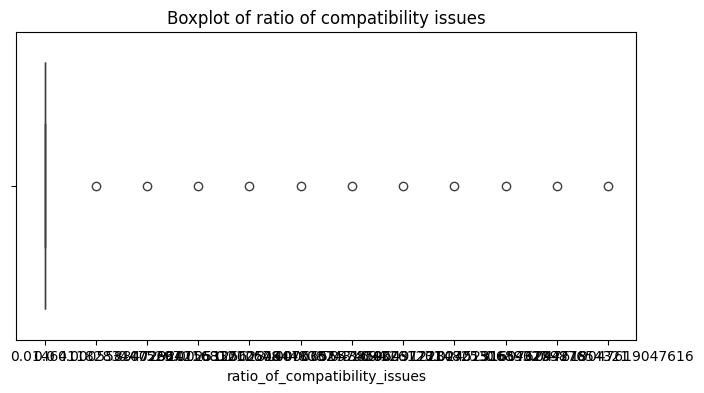

count     181
unique     12
top       0.0
freq      170
Name: ratio_of_compatibility_issues, dtype: object


In [ ]:
# Determine distribution of the data (are there outliers?)

import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with missing values in 'time_taken_to_merge'
df = df[df['ratio_of_compatibility_issues'] != 'Not Apply']

# Boxplot to visualize outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['ratio_of_compatibility_issues'])
plt.title('Boxplot of ratio of compatibility issues')
plt.show()

# Print descriptive statistics for the column
print(df['ratio_of_compatibility_issues'].describe())


In [4]:
from datetime import time
"""
Data Processing
"""

# Deal with empty data

# """
# Option 1: Drop rows with 'Not Apply'
# """
# df = df[df.apply(lambda row: 'Not Apply' not in row.astype(str).values, axis=1)]
# print(f"Row count after dropping 'Not Apply': {len(df)}")


"""
Option 2: Replace with other values
"""
# Replace 'Not Apply' with 0.0 in 'ratio_of_compatibility_issues'
df['ratio_of_compatibility_issues'] = df['ratio_of_compatibility_issues'].replace('Not Apply', 0.0)

# Replace 'Not Apply' with the mean in 'time_taken_to_merge'
df_filtered = df[df['time_taken_to_merge'] != 'Not Apply']
df_filtered['time_taken_to_merge'] = pd.to_numeric(df_filtered['time_taken_to_merge'], errors='coerce')
mean_time_taken_to_merge = df_filtered['time_taken_to_merge'].mean()
df['time_taken_to_merge'] = df['time_taken_to_merge'].replace('Not Apply', mean_time_taken_to_merge)

for col in ['ratio_of_compatibility_issues', 'time_taken_to_merge']:
    df[col] = pd.to_numeric(df[col], errors='coerce')




# Drop all columns that contains lists
df = df.drop(columns=[col for col in df.columns if 'list' in col])

# Create X and y data
X = df.drop(columns=['is_sustaining', 'repo_owner', 'repo_name', 'repo_id'])
y = df['is_sustaining']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed


<ipython-input-4-5496539a64ce>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time_taken_to_merge'] = pd.to_numeric(df_filtered['time_taken_to_merge'], errors='coerce')


SVM Accuracy: 0.7142857142857143
SVM F1-Score: 0.7948717948717948
SVM ROC-AUC: 0.804093567251462


/usr/local/lib/python3.11/dist-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


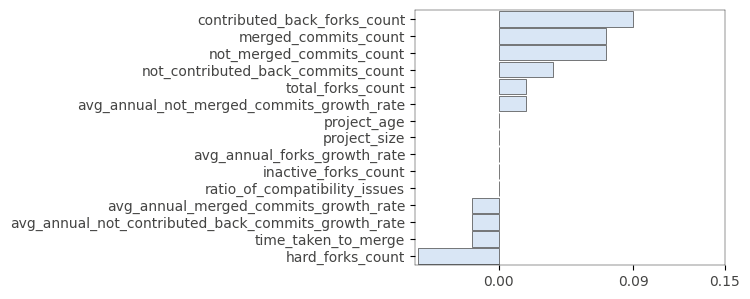

In [17]:
# Train SVM model

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy}")
print(f"SVM F1-Score: {f1_svm}")

y_probabilities = svm_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probabilities)
print(f"SVM ROC-AUC: {roc_auc}")

# Measure feature importance using permutation importances
imp = importances(svm_model, X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

Random Forest Accuracy: 0.8571428571428571
Random Forest F1-Score: 0.8888888888888888
Random Forest ROC-AUC: 0.9173976608187134


/usr/local/lib/python3.11/dist-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


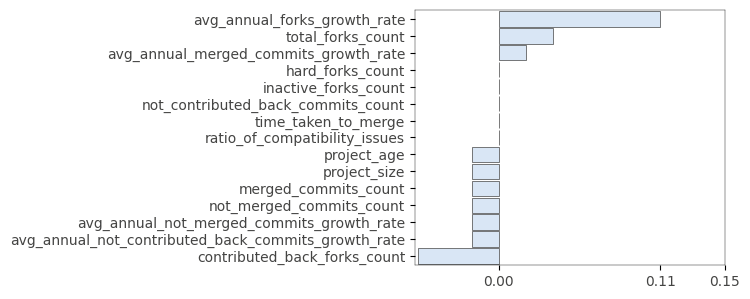

In [14]:
# Train Random Forest model

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)


# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
print(f"Random Forest F1-Score: {f1_rf}")

y_probabilities = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probabilities)
print(f"Random Forest ROC-AUC: {roc_auc}")

# Measure feature importance using permutation importances
imp = importances(rf_model, X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

XGBoost Accuracy: 0.8928571428571429
XGBoost F1-Score: 0.918918918918919
XGBoost ROC-AUC: 0.8786549707602339


/usr/local/lib/python3.11/dist-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


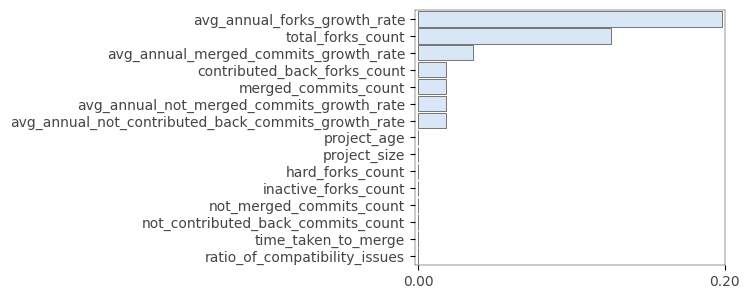

In [15]:
# Train XGBoost model

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")
print(f"XGBoost F1-Score: {f1_xgb}")

y_probabilities = xgb_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probabilities)
print(f"XGBoost ROC-AUC: {roc_auc}")

# Measure feature importance using permutation importances
imp = importances(xgb_model, X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()